In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [3]:
df_biomass = pd.read_csv('data/fermentation raw data/biomass_OD.csv', sep=';')
df_hplc = pd.read_csv('data/pre treated/HPLC.csv', sep=';')

In [4]:
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.rename(columns={'hours': 'time [h]', 'biomass (g/L)': 'Biomass [g/L]'}, inplace=True)
df_biomass.head(1)

,Biomass [g/L],time [h]
0,0.694,0.2


In [5]:
for col in df_hplc.columns:
     df_hplc[col] = df_hplc[col].astype(str).str.replace(',', '.')
     df_hplc[col] = df_hplc[col].replace('nan', float('nan'))
     df_hplc[col] = pd.to_numeric(df_hplc[col])
df_hplc.rename(columns={'Time [h]': 'time [h]'}, inplace=True)
df_hplc.head(2)

,time [h],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L],Glucose2 [g/L],Glucose [g/L].1,added Glucose [g],Consumed_Glucose [g],Consumed_Glucose [g/L],Volume at each time point
0,0.2,10.44,0.17,0.04,0.01,0.08,5.22,5.22,10.44,0.00,0.00,1.0
1,2.1,10.35,0.16,0.03,0.03,0.10,5.18,5.18,10.44,0.09,0.09,1.0


In [6]:
df_Yxs = df_biomass.merge(df_hplc, on='time [h]', how='left')

Assumption made that the parameters mu, Yxs and qs are constant for the model even though they're changing due to fermentation conditions.

In [7]:
# calculating the growth rate 
# with 2 approaches:
## 1) from 1 to the sample points ; 2) between the two closest sample points: without log, because no exponential growth 
# df_Yxs['mu 1 [1/h]'] = (np.log(df_Yxs['Biomass [g/L]']) - np.log(df_Yxs['Biomass [g/L]'].iloc[0])) / (df_Yxs['time [h]'] - df_Yxs['time [h]'].iloc[0])
df_Yxs['mu between direct samples [1/h]'] = (abs(df_Yxs['Biomass [g/L]'].diff()) / abs(df_Yxs['time [h]'].diff()))/df_Yxs['Biomass [g/L]'].shift(1)

In [8]:
# calculating the yield coefficient of biomass over substrate with 3 approaches: (all of them are based on the assumption that glucose is consumed, actually we dont know at all, how much is consumed)
#df_Yxs['Yxs 1.1 [gx/gs]'] = (df_Yxs['Biomass [g/L]'] - df_Yxs['Biomass [g/L]'].iloc[0]) / (df_Yxs['Glucose [g/L]'] - df_Yxs['Glucose [g/L]'].iloc[0])
#df_Yxs['Yxs 1.2 [gx/gs]'] = abs(df_Yxs['Biomass [g/L]'] - df_Yxs['Biomass [g/L]'].iloc[0]) / abs(df_Yxs['Glucose [g/L]'] - df_Yxs['Glucose [g/L]'].iloc[0])
# df_Yxs['Yxs 2.1 [gx/gs]'] = df_Yxs['Biomass [g/L]'].diff() / df_Yxs['Consumed_Glucose [g/L]'].diff()
df_Yxs['Yxs [gx/gs]'] = abs(df_Yxs['Biomass [g/L]'].diff()) / abs(df_Yxs['Consumed_Glucose [g/L]'].diff())

# 1) qs ds/dt/x = mu/Yxs
df_Yxs['qs 1 - ds/dt/x - [1/h]'] = (abs(df_Yxs['Consumed_Glucose [g/L]'].diff()) / abs(df_Yxs['time [h]'].diff()))/df_Yxs['Biomass [g/L]'].shift(1)

# 2) qs 
# df_Yxs['qs 2 - mu/Yxs -[1/h]'] = df_Yxs['mu between direct samples [1/h]']/ df_Yxs['Yxs [gx/gs]']

Plot: dynamics of qs, mu and Yx/s

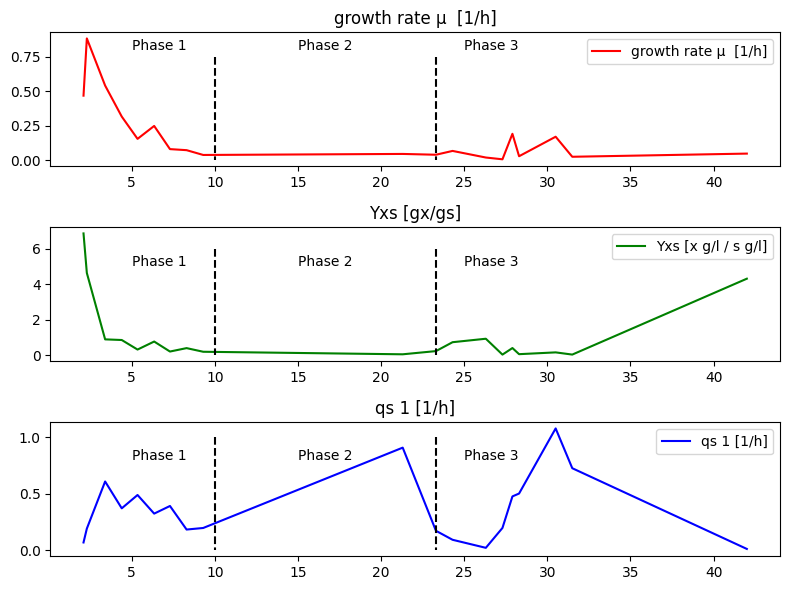

In [9]:
# Create a new figure and set the size
plt.figure(figsize=(8, 6))

# Plot the first subplot
plt.subplot(3, 1, 1)  # (rows, columns, plot_number)
plt.plot(df_Yxs['time [h]'], df_Yxs['mu between direct samples [1/h]'], 'r-', label='growth rate μ  [1/h]')
plt.title('growth rate μ  [1/h]')
plt.legend()

# Add annotation for phase 1
plt.annotate('Phase 1', xy=(10, 0.6), xytext=(5, 0.8))
plt.plot([10, 10], [0.75, 0], 'k--')
# Add annotation for phase 2
plt.annotate('Phase 2', xy=(23.3, 0.3), xytext=(15, 0.8))
plt.plot([23.3, 23.3], [0.75, 0], 'k--')
plt.annotate('Phase 3', xy=(42, 0.3), xytext=(25, 0.8))

# Plot the second subplot
plt.subplot(3, 1, 2)  # (rows, columns, plot_number)
plt.plot(df_Yxs['time [h]'], df_Yxs['Yxs [gx/gs]'], 'g-', label='Yxs [x g/l / s g/l]')
plt.title('Yxs [gx/gs]')
plt.legend()

# Add annotation for phase 1
plt.annotate('Phase 1', xy=(10, 0.6), xytext=(5, 5))
plt.plot([10, 10], [6, 0], 'k--')
# Add annotation for phase 2
plt.annotate('Phase 2', xy=(23, 0.6), xytext=(15, 5))
plt.plot([23.3, 23.3], [6, 0], 'k--')
# Add annotation for phase 3
plt.annotate('Phase 3', xy=(42, 0.3),  xytext=(25, 5))

# Plot the third subplot
plt.subplot(3, 1, 3)  # (rows, columns, plot_number)
plt.plot(df_Yxs['time [h]'], df_Yxs['qs 1 - ds/dt/x - [1/h]'] , 'b-', label='qs 1 [1/h]')
plt.title('qs 1 [1/h]')
plt.legend()

# Add annotation for phase 1
plt.annotate('Phase 1', xy=(10, 0.6), xytext=(5, 0.8))
plt.plot([10, 10], [1, 0], 'k--')
# Add annotation for phase 2
plt.annotate('Phase 2', xy=(23, 0.6), xytext=(15, 0.8))
plt.plot([23.3, 23.3], [1, 0], 'k--')

plt.annotate('Phase 3', xy=(42, 0.6), xytext=(25, 0.8))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Calculation how much glucose was fed in total when the last sample was taken:

1. Feed started as ramp at **start_feed_ramp**
2. Feed was constant starting after **start_feed_const**
3. Feed was stopped at **end_feed**

In [10]:
start_feed_ramp = 9.92 # Start time of linear feed rate (hours)
start_feed_const = 28  # End time of linear feed rate (hours)
end_feed = 28 # Time when feed rate ends  (hours)

feed_rate_start = 0.005  # Initial feed rate (L/h)
feed_rate_end = 0.063   # Final feed rate (L/h)
feed_rate_constant = 0.102  # Constant feed rate (L/h)

feed_concentration = 350  # Concentration of feed solution (g/L)
fermentation_time = end_feed  # Total fermentation time (hours)

# Calculate the duration of ramp and constant feeding
ramp_duration = start_feed_const - start_feed_ramp
constant_duration = end_feed - start_feed_const

print(f'ramp feed for {ramp_duration} h & constant feed for {constant_duration} h')

ramp feed for 18.08 h & constant feed for 0 h


In [11]:
# Calculating the average feed rate based on the start and end value
avg_feedrate_ramp = (feed_rate_start + feed_rate_end) / 2 #[L/h]


# Calculating the total volume 
feed_volume_ramp = avg_feedrate_ramp * ramp_duration #[L]

# Same for constant feeding phase
feed_volume_const = feed_rate_constant * constant_duration #[L]

# Total feed volume
total_glucose = feed_volume_ramp + feed_volume_const #[L]

# Calculate the total amount of glucose in grams
total_glucose_grams = total_glucose * feed_concentration #[gs]
print("Total amount of glucose after {} hours: {:.2f} grams".format(fermentation_time, total_glucose_grams))

Total amount of glucose after 28 hours: 215.15 grams


Calculating the amount of glc added just for the time slots inside the ramp

In [12]:
start_feed_ramp1 = 9.92 # Start time of linear feed rate (hours)
start_feed_const1 = 21.3 # changes this value to each sample point and run it


# Calculating the average feed rate based on the start and end value
avg_feedrate_ramp = (feed_rate_start + feed_rate_end) / 2 #[L/h]

ramp_duration = start_feed_const1 - start_feed_ramp1 # [h]

# Calculating the total volume 
feed_volume_ramp = avg_feedrate_ramp * ramp_duration #[L]

# Calculate the total amount of glucose in grams
total_glucose_grams = feed_volume_ramp * feed_concentration #[gs]

print("Total amount of glucose" , total_glucose_grams)

Total amount of glucose 135.42200000000003


In [13]:
# over the whole fed-batch phase: adding 350 g/l (1l) to 1 L, --> 175 g/l  without consumption 
Yxs_consumed = (23.1 - 5.5)/(175-120.48)

print(Yxs_consumed)

0.3228173147468819
